소프트맥스 회귀로 MNIST 데이터를 분류하는 실습을 해봤습니다. 소프트맥스 회귀 또한 인공 신경망이라고 볼 수 있는데, 입력층과 출력층만 존재하므로 소프트맥스 함수를 활성화 함수로 사용한 '단층 퍼셉트론'이라고 할 수 있습니다. 이번 챕터에서는 은닉층을 추가로 넣어 다층 퍼셉트론을 구현하고, 딥 러닝을 통해서 MNIST 데이터를 분류해봅시다.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from torch import nn
from torch import optim


In [9]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.data[0]
mnist.target[0]

'5'

In [11]:
mnist.target = mnist.target.astype(np.int8)
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target


이 이미지 데이터의 레이블은 5이다


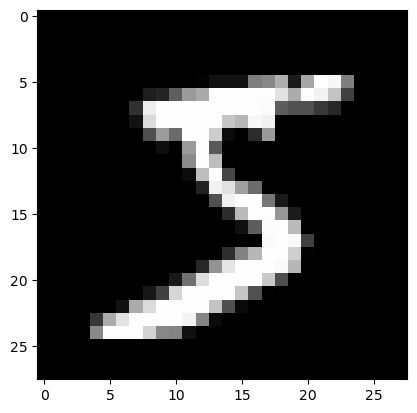

In [12]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

훈련 데이터와 테스트 데이터의 분리

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)
#test_size=1/7은 데이터의 1/7을 테스트 데이터로 사용하고 나머지 6/7을 학습 데이터로 사용하겠다는 의미입니다.
#random_state=0은 데이터 분할을 고정하여 코드 실행 시 같은 결과를 재현할 수 있도록 합니다.

In [15]:
# 텐서로 변환
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# TensorDataset 객체 생성
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader 객체 생성
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)


TensorDataset 객체 생성

X_train, y_train (또는 X_test, y_test) 텐서를 하나의 데이터셋으로 결합하여, 각 샘플과 해당 레이블을 함께 다루기 쉽게 만듭니다.

DataLoader 객체 생성

학습(또는 테스트) 도중 데이터를 배치(batch) 단위로 읽어들여, 메모리 효율성과 학습 효율성을 높입니다.
loader_train에서는 shuffle=True로 데이터를 섞어, 학습 시 모델이 데이터 순서에 영향을 받지 않도록 합니다.
loader_test에서는 shuffle=False로, 평가 시 일관된 순서를 유지합니다.


In [17]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

# 28 * 28 크기의 입력 층
# 100개의 뉴런을 가진 은닉층 1개개
# 10개의 출력 층 (0~9)


Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [18]:
# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [19]:
# 총 3번의 에포크 동안 모델 학습
epochs = 3

for epoch in range(epochs):
  for data, targets in loader_train:
    optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
    y_pred = model(data)          # 순전파 연산으로 예측값 계산
    loss = loss_fn(y_pred, targets)  # 손실 함수로 비용 계산
    loss.backward()            # 역전파 연산으로 기울기 계산
    optimizer.step()           # 옵티마이저를 통해 파라미터 업데이트

  print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch + 1, 3, loss.item()))


Epoch    1/3 Cost: 0.096257
Epoch    2/3 Cost: 0.264811
Epoch    3/3 Cost: 0.029315


In [20]:
model.eval()  # 신경망을 추론 모드로 전환
correct = 0

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data, targets in loader_test:

        outputs = model(data)  # 데이터를 입력하고 출력을 계산

        # 추론 계산
        _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
        correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

# 정확도 출력
data_num = len(loader_test.dataset)  # 데이터 총 건수
print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))



테스트 데이터에서 예측 정확도: 9580/10000 (96%)



예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


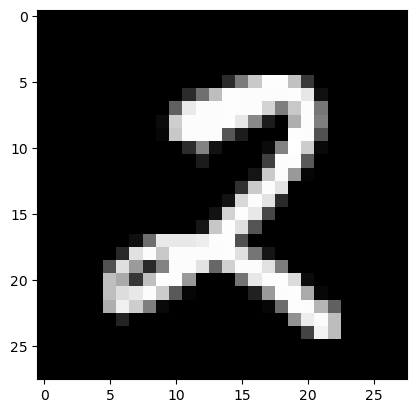

In [21]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))
